# Descuentos por volúmen | Utilización según tipo de negocio


En este trabajo nos proponemos caracterizar la forma en que los distintos negocios utilizan los descuentos por volumen. La pregunta de investigación es: ¿los distintos tipos de negocios utilizan de forma distinta los descuentos por volumen?

Con el término 'la forma de utilización de los descuentos' nos referimos al tipo de producto comprado bajo un descuento de volumen, la cantidad de unidades compradas en promedio y el descuento particular utilizado.


Nuestras hipótesis pueden expresarse como:

GENERAL: Los distintos tipos de cliente se diferencian en la forma de utilizar los descuentos por volumen

* El tipo de cliente influye en el promedio de unidades compradas bajo una oferta de volumen

* El tipo de cliente influye en el descuento particular utilizado de las ofertas de volumen

* El tipo de cliente influye en la proporción de líneas con descuento respecto al total de líneas

* El tipo de cliente influye en la categoría de producto comprado bajo una oferta por volumen


Nos enfocaremos en:

1) Caracterizar a los tipos de clientes de la empresa y su comportamiento de compra

2) Caracterizar a los descuentos por volumen (qué productos los aplican, cuántas unidades vendidas acumulan, promedio de unidades las líneas de las ordenes que los utilizan)

3) Caracterizar la relación entre los distintos tipos de clientes y los descuentos por volumen (qué tipos de productos compran, cuántas unidades compran en promedio y qué descuento es el que más utilizan)

Librerías

In [23]:
%pip install pymssql

In [24]:
%pip install colorama

In [25]:
import pymssql
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
from colorama import Fore, Back, Style


import sys

Conexión al servidor

In [26]:
server = '157.92.26.17'
user = 'Alumno'
password = 'mrcd2023'

conn = pymssql.connect(server=server, user=user, password=password, port = '1443')
cursor = conn.cursor()

Obtenemos datos para descripción general de los clientes (Business Type)

In [27]:
QUERY = """
WITH CTE AS (
    SELECT r.BusinessType, SalesOrderNumber,
    CONCAT(SalesOrderNumber, '-', SalesOrderLineNumber) AS LineId,
    CASE WHEN PromotionKey IN(2,3,4,5,6) THEN 'VolProm' ELSE 'noVolProm' END volProm,
    OrderQuantity

    FROM AdventureWorksDW2019.dbo.FactResellerSales rs
    --inner porque solo nos interesan las ventas con un reseller asociado
    INNER JOIN AdventureWorksDW2019.dbo.DimReseller r
    ON rs.ResellerKey = r.ResellerKey
)

SELECT DISTINCT BusinessType, volProm,

--lines
COUNT(LineId) OVER(PARTITION BY BusinessType, volProm)
AS BusinessPromNumLines,

COUNT(LineId) OVER(PARTITION BY BusinessType)
AS BusinessNumLines,

COUNT(LineId) OVER(PARTITION BY BusinessType, volProm) * 1.0 / (COUNT(LineId) OVER(PARTITION BY BusinessType))
AS percBusinessPromLines,

COUNT(LineId) OVER(PARTITION BY BusinessType) * 1.0 / (COUNT(LineId) OVER())
AS percBusinessNumLines,

--------
--units
SUM(OrderQuantity) OVER(PARTITION BY BusinessType, VolProm)
AS BusinessPromNumUnits,

SUM(OrderQuantity) OVER(PARTITION BY BusinessType)
AS BusinessNumUnits,

SUM(OrderQuantity) OVER(PARTITION BY BusinessType, volProm)* 1.0 / (SUM(OrderQuantity) OVER(PARTITION BY BusinessType))
AS percBusinessPromNumUnits,

SUM(OrderQuantity) OVER(PARTITION BY BusinessType)* 1.0 / (SUM(OrderQuantity) OVER())
AS percBusinessNumUnits,

AVG(OrderQuantity * 1.0) OVER(PARTITION BY BusinessType, volProm)
AS avgBusinessPromOrderQty,

AVG(OrderQuantity * 1.0) OVER(PARTITION BY BusinessType)
AS avgBusinessOrderQty


FROM CTE
ORDER BY BusinessType, volProm

               """

cursor.execute(QUERY)
rows = cursor.fetchall()
column_names = [item[0] for item in cursor.description]
df_business_gral = pd.DataFrame(rows, columns=column_names)

Utilización de promociones según business type



In [28]:
QUERY = """
WITH CTE AS (
    SELECT rs.ProductKey, pc.ProductCategoryKey, pc.EnglishProductCategoryName, ps.ProductSubcategoryKey, ps.EnglishProductSubcategoryName,
    r.BusinessType, SalesOrderNumber, PromotionKey,
    CONCAT(SalesOrderNumber, '-', SalesOrderLineNumber) AS LineId, OrderQuantity

    FROM AdventureWorksDW2019.dbo.FactResellerSales rs
    LEFT JOIN AdventureWorksDW2019.dbo.DimReseller r
    ON rs.ResellerKey = r.ResellerKey
    LEFT JOIN AdventureWorksDW2019.dbo.DimProduct dp
    ON rs.ProductKey = dp.ProductKey
    LEFT JOIN AdventureWorksDW2019.dbo.DimProductSubcategory ps
    ON dp.ProductSubcategoryKey = ps.ProductSubcategoryKey
    LEFT JOIN AdventureWorksDW2019.dbo.DimProductCategory pc
    ON ps.ProductCategoryKey = pc.ProductCategoryKey
)

SELECT DISTINCT BusinessType, PromotionKey,

--lines
COUNT(LineId) OVER(PARTITION BY BusinessType, PromotionKey)
AS BusinessPromKeyNumLines,

COUNT(LineId) OVER(PARTITION BY BusinessType)
AS BusinessNumLines,

COUNT(LineId) OVER(PARTITION BY BusinessType, PromotionKey) * 1.0 /  (COUNT(LineId) OVER(PARTITION BY BusinessType))
AS percBusinessPromKeyLines,

COUNT(LineId) OVER(PARTITION BY BusinessType) * 1.0 /  (COUNT(LineId) OVER())
AS percBusinessNumLines,

-----

--units
SUM(OrderQuantity) OVER(PARTITION BY BusinessType, PromotionKey)
AS BusinessPromKeyNumUnits,

SUM(OrderQuantity) OVER(PARTITION BY BusinessType)
AS BusinessNumUnits,

SUM(OrderQuantity) OVER(PARTITION BY BusinessType, PromotionKey)* 1.0 /  SUM(OrderQuantity) OVER(PARTITION BY BusinessType)
AS percBusinessPromKeyNumUnits,

SUM(OrderQuantity) OVER(PARTITION BY BusinessType) * 1.0 /  (SUM(OrderQuantity) OVER())
AS percBusinessNumUnits,

AVG(OrderQuantity*1.0) OVER(PARTITION BY BusinessType, PromotionKey)
AS avgBusinessPromKeyOrderQty



FROM CTE
ORDER BY BusinessType, PromotionKey

               """

cursor.execute(QUERY)
rows = cursor.fetchall()
column_names = [item[0] for item in cursor.description]
df_business_by_prom = pd.DataFrame(rows, columns=column_names)

Relación entre business type y promociones por volumen

In [29]:
QUERY = """
WITH CTE AS (
    SELECT rs.ProductKey, pc.ProductCategoryKey, pc.EnglishProductCategoryName, ps.ProductSubcategoryKey, ps.EnglishProductSubcategoryName,
    r.BusinessType, SalesOrderNumber,
    CONCAT(SalesOrderNumber, '-', SalesOrderLineNumber) AS LineId,
    CASE WHEN PromotionKey IN(2,3,4,5,6) THEN 'VolProm' ELSE 'noVolProm' END volProm,
    OrderQuantity

    FROM AdventureWorksDW2019.dbo.FactResellerSales rs
    LEFT JOIN AdventureWorksDW2019.dbo.DimReseller r
    ON rs.ResellerKey = r.ResellerKey
    LEFT JOIN AdventureWorksDW2019.dbo.DimProduct dp
    ON rs.ProductKey = dp.ProductKey
    LEFT JOIN AdventureWorksDW2019.dbo.DimProductSubcategory ps
    ON dp.ProductSubcategoryKey = ps.ProductSubcategoryKey
    LEFT JOIN AdventureWorksDW2019.dbo.DimProductCategory pc
    ON ps.ProductCategoryKey = pc.ProductCategoryKey
)

SELECT DISTINCT BusinessType, volProm, EnglishProductCategoryName,

--lines
COUNT(LineId) OVER(PARTITION BY BusinessType, volProm, ProductCategoryKey)
AS BusinessCatPromNumLines,

COUNT(LineId) OVER(PARTITION BY BusinessType, ProductCategoryKey)
AS BusinessCatLines,

COUNT(LineId) OVER(PARTITION BY BusinessType, volProm, ProductCategoryKey) * 1.0 /  (COUNT(LineId) OVER(PARTITION BY BusinessType, ProductCategoryKey))
AS percBusinessCatPromLines,

COUNT(LineId) OVER(PARTITION BY BusinessType, ProductCategoryKey) * 1.0 /  (COUNT(LineId) OVER(PARTITION BY BusinessType))
AS percBusinessCatLines,


--units
SUM(OrderQuantity) OVER(PARTITION BY BusinessType, volProm, ProductCategoryKey)
AS BusinessCatPromNumUnits,

SUM(OrderQuantity) OVER(PARTITION BY BusinessType, ProductCategoryKey)
AS BusinessCatNumUnits,

SUM(OrderQuantity) OVER(PARTITION BY BusinessType, volProm, ProductCategoryKey)* 1.0 /  SUM(OrderQuantity) OVER(PARTITION BY BusinessType, ProductCategoryKey)
AS percBusinessCatPromNumUnits,

SUM(OrderQuantity) OVER(PARTITION BY BusinessType, ProductCategoryKey) * 1.0 /  (SUM(OrderQuantity) OVER(PARTITION BY BusinessType))
AS percBusinessCatNumUnits,

SUM(OrderQuantity) OVER(PARTITION BY BusinessType, ProductCategoryKey) * 1.0 /  (SUM(OrderQuantity) OVER(PARTITION BY ProductCategoryKey))
AS percGlobalBusinessCatNumUnits,

AVG(OrderQuantity*1.0) OVER(PARTITION BY BusinessType, volProm, ProductCategoryKey)
AS avgBusinessPromCatOrderQty



FROM CTE
ORDER BY BusinessType, EnglishProductCategoryName, volProm
               """

cursor.execute(QUERY)
rows = cursor.fetchall()
column_names = [item[0] for item in cursor.description]
df_business_by_cat = pd.DataFrame(rows, columns=column_names)

Time series

In [30]:
QUERY = """
WITH normalized_sales AS
(
SELECT
 	frs.*,
 	(frs.SalesAmount * fcr.EndOfDayRate * 1.0) AS NormalizedSales
FROM AdventureWorksDW2019.dbo.FactResellerSales frs
 	INNER JOIN AdventureWorksDW2019.dbo.FactCurrencyRate fcr
		ON frs.OrderDateKey = fcr.DateKey
		AND frs.CurrencyKey = fcr.CurrencyKey
),
sales_by_day AS
(
SELECT
 	CAST(OrderDate AS DATE) AS OrderDate, SUM(NormalizedSales) AS Sales
FROM normalized_sales ns
GROUP BY CAST(OrderDate AS DATE)
)
SELECT
 	*,
 	ROUND(AVG(Sales) OVER(ORDER BY OrderDate ROWS BETWEEN 1 PRECEDING AND 1 FOLLOWING), 2) AS SalesMovingAverage
FROM sales_by_day;
                """

cursor.execute(QUERY)

rows = cursor.fetchall()
column_names = [item[0] for item in cursor.description]

time_series_medias_moviles = pd.DataFrame(rows, columns=column_names)


In [31]:
QUERY = """
WITH normalized_sales AS
(
SELECT
	frs.*,
	(frs.SalesAmount * fcr.EndOfDayRate * 1.0) AS NormalizedSales,
	dpc.EnglishProductCategoryName
FROM AdventureWorksDW2019.dbo.FactResellerSales frs
	INNER JOIN AdventureWorksDW2019.dbo.FactCurrencyRate fcr
		ON frs.OrderDateKey = fcr.DateKey
		AND frs.CurrencyKey = fcr.CurrencyKey
	INNER JOIN AdventureWorksDW2019.dbo.DimProduct dp ON frs.ProductKey = dp.ProductKey
	INNER JOIN AdventureWorksDW2019.dbo.DimProductSubcategory dps ON dp.ProductSubcategoryKey = dps.ProductSubcategoryKey
	INNER JOIN AdventureWorksDW2019.dbo.DimProductCategory dpc ON dps.ProductCategoryKey = dpc.ProductCategoryKey
),
sales_by_day AS
(
SELECT
	CAST(OrderDate AS DATE) AS OrderDate, SUM(NormalizedSales) AS Sales,
	EnglishProductCategoryName
FROM normalized_sales ns
GROUP BY CAST(OrderDate AS DATE), EnglishProductCategoryName
)
SELECT
	*,
	ROUND(AVG(Sales) OVER(ORDER BY OrderDate ROWS BETWEEN 1 PRECEDING AND 1 FOLLOWING), 2) AS SalesMovingAverage
FROM sales_by_day;
                """

cursor.execute(QUERY)

rows = cursor.fetchall()
column_names = [item[0] for item in cursor.description]

time_series_por_producto = pd.DataFrame(rows, columns=column_names)

Proporcion de ventas por producto por cliente, sobre total vendido y sobre total vendido con promoción

In [43]:
QUERY = """
WITH productos_por_reseller AS
(
SELECT
	dr.BusinessType,
	dpc.EnglishProductCategoryName,
	COUNT(DISTINCT frs.ProductKey ) AS total_distintos_productos_comprados,
	COUNT(*) AS total_cantidad_lineas,
	SUM(frs.OrderQuantity) AS total_cantidad_unidades,
	ROUND(SUM(frs.SalesAmount * fcr.EndOfDayRate * 1.0), 2) AS total_normalized_sales_amount
FROM AdventureWorksDW2019.dbo.FactResellerSales frs
	INNER JOIN AdventureWorksDW2019.dbo.DimProduct dp ON frs.ProductKey = dp.ProductKey
	INNER JOIN AdventureWorksDW2019.dbo.DimProductSubcategory dps ON dps.ProductSubcategoryKey = dp.ProductSubcategoryKey
	INNER JOIN AdventureWorksDW2019.dbo.DimProductCategory dpc on dps.ProductCategoryKey = dpc.ProductCategoryKey
	INNER JOIN AdventureWorksDW2019.dbo.DimReseller dr ON frs.ResellerKey = dr.ResellerKey
	INNER JOIN AdventureWorksDW2019.dbo.FactCurrencyRate fcr on frs.OrderDateKey = fcr.DateKey
GROUP BY dr.BusinessType, dpc.EnglishProductCategoryName
),
productos_por_reseller_promo AS
(
SELECT
	dr.BusinessType,
	dpc.EnglishProductCategoryName,
	COUNT(DISTINCT frs.ProductKey ) AS promo_distintos_productos_comprados,
	COUNT(*) AS promo_cantidad_lineas,
	SUM(frs.OrderQuantity) AS promo_cantidad_unidades,
	ROUND(SUM(frs.SalesAmount * fcr.EndOfDayRate * 1.0), 2) AS promo_normalized_sales_amount
FROM AdventureWorksDW2019.dbo.FactResellerSales frs
	INNER JOIN AdventureWorksDW2019.dbo.DimProduct dp ON frs.ProductKey = dp.ProductKey
	INNER JOIN AdventureWorksDW2019.dbo.DimProductSubcategory dps ON dps.ProductSubcategoryKey = dp.ProductSubcategoryKey
	INNER JOIN AdventureWorksDW2019.dbo.DimProductCategory dpc on dps.ProductCategoryKey = dpc.ProductCategoryKey
	INNER JOIN AdventureWorksDW2019.dbo.DimReseller dr ON frs.ResellerKey = dr.ResellerKey
	INNER JOIN AdventureWorksDW2019.dbo.FactCurrencyRate fcr on frs.OrderDateKey = fcr.DateKey
WHERE frs.PromotionKey IN (2,3,4,5,6)
GROUP BY dr.BusinessType, dpc.EnglishProductCategoryName
),
business_category AS
(
	SELECT BusinessType, EnglishProductCategoryName
	FROM
	(
	SELECT DISTINCT DR.BusinessType , 1 as join_column
	FROM AdventureWorksDW2019.dbo.DimReseller dr
	) a
	INNER JOIN
	(
	SELECT DISTINCT dpc.EnglishProductCategoryName, 1 as join_column
	FROM AdventureWorksDW2019.dbo.DimProductCategory dpc
	) b
	ON a.join_column = b.join_column
),
metrics AS
(
SELECT
	ppr.*,
	pprp.promo_distintos_productos_comprados,
	pprp.promo_cantidad_lineas,
	pprp.promo_cantidad_unidades,
	pprp.promo_normalized_sales_amount,
	(pprp.promo_distintos_productos_comprados*1.0/ ppr.total_distintos_productos_comprados*1.0) AS proporcion_productos_en_promo,
	(pprp.promo_cantidad_lineas*1.0 / ppr.total_cantidad_lineas*1.0) AS proporcion_lineas_con_promo,
	(pprp.promo_cantidad_unidades*1.0 / ppr.total_cantidad_unidades*1.0) AS proporcion_unidades_con_promo,
	(pprp.promo_normalized_sales_amount*1.0 / ppr.total_normalized_sales_amount*1.0) AS proporcion_ventas_con_promo,
	SUM(total_normalized_sales_amount) OVER(PARTITION BY ppr.BusinessType) AS total_ventas_por_cliente,
	SUM(promo_normalized_sales_amount) OVER(PARTITION BY ppr.BusinessType) AS promo_ventas_por_cliente,
	SUM(total_normalized_sales_amount) OVER(PARTITION BY ppr.EnglishProductCategoryName) AS total_ventas_por_producto,
	SUM(promo_normalized_sales_amount) OVER(PARTITION BY ppr.EnglishProductCategoryName) AS promo_ventas_por_producto
FROM business_category bc
	LEFT JOIN productos_por_reseller ppr ON bc.BusinessType = ppr.BusinessType
		AND bc.EnglishProductCategoryName = ppr.EnglishProductCategoryName
	LEFT JOIN productos_por_reseller_promo pprp ON bc.BusinessType = pprp.BusinessType
		AND bc.EnglishProductCategoryName = pprp.EnglishProductCategoryName
)
SELECT
	*,
	(total_normalized_sales_amount / total_ventas_por_cliente ) AS proporcion_total_venta_producto_en_cliente,
	(total_normalized_sales_amount / total_ventas_por_producto ) AS proporcion_total_venta_cliente_en_producto,
	(promo_normalized_sales_amount / promo_ventas_por_cliente ) AS proporcion_promo_venta_producto_en_cliente,
	(promo_normalized_sales_amount / promo_ventas_por_producto ) AS proporcion_promo_venta_cliente_en_producto
FROM metrics
ORDER BY 1,2;

SELECT
	COUNT(DISTINCT frs.ProductKey)
FROM AdventureWorksDW2019.dbo.FactResellerSales frs
	INNER JOIN AdventureWorksDW2019.dbo.DimProduct dp ON frs.ProductKey = dp.ProductKey
	INNER JOIN AdventureWorksDW2019.dbo.DimProductSubcategory dps ON dps.ProductSubcategoryKey = dp.ProductSubcategoryKey
	INNER JOIN AdventureWorksDW2019.dbo.DimProductCategory dpc on dps.ProductCategoryKey = dpc.ProductCategoryKey
	INNER JOIN AdventureWorksDW2019.dbo.DimReseller dr ON frs.ResellerKey = dr.ResellerKey
WHERE 1=1
	AND dr.BusinessType = 'Value Added Reseller'
	AND dpc.EnglishProductCategoryName = 'Clothing'
	AND frs.PromotionKey != 1;
                """

cursor.execute(QUERY)

rows = cursor.fetchall()
column_names = [item[0] for item in cursor.description]

product_categories_analysis = pd.DataFrame(rows, columns=column_names)

1) Caracterizar a los tipos de clientes de la empresa y su comportamiento de compra

En esta tabla caracterizamos en general a los Business Type. Observamos que los Warehouse son el tipo de cliente más grande del que dispone la compañia, acumulando el 45% de las líneas de órdenes realizadas y el 52% de las unidades compradas. Asimismo, tienen el mayor promedio de unidades compradas por línea de orden. Por otra parte, los Speciality Bike Shops tienen la menor cantidad de líneas (13%) y la menor cantidad de unidades compradas (10%), constituyendo el tipo de cliente más pequeño.

In [32]:
tabla_formateada = tabulate(df_business_gral[['BusinessType', 'BusinessNumLines', 'percBusinessNumLines', 'BusinessNumUnits', 'percBusinessNumUnits', 'avgBusinessOrderQty']].drop_duplicates(),
                            tablefmt="simple_outline",
                            headers='keys',
                            showindex=False)

print(tabla_formateada)


BusinessType            BusinessNumLines    percBusinessNumLines    BusinessNumUnits    percBusinessNumUnits    avgBusinessOrderQty
--------------------  ------------------  ----------------------  ------------------  ----------------------  ---------------------
Specialty Bike Shop                 7987                0.131246               22076                0.102977                2.76399
Value Added Reseller               25134                0.413015               80309                0.374614                3.19523
Warehouse                          27734                0.455739              111993                0.522409                4.03811


Unidades compradas

Para cada cliente
- proporción de cada tipo de producto

Para cada tipo de producto
- Proporción comprada por cada cliente

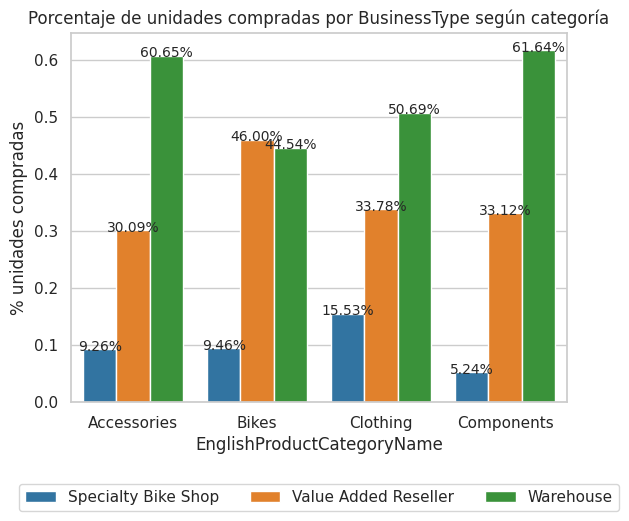

In [33]:
df_business_by_cat['percGlobalBusinessCatNumUnits'] = pd.to_numeric(df_business_by_cat['percGlobalBusinessCatNumUnits'], errors='coerce')


sns.set(style="whitegrid")


ax = sns.barplot(x='EnglishProductCategoryName', y='percGlobalBusinessCatNumUnits',
                 hue='BusinessType',
                 data=df_business_by_cat,
                 palette='tab10')

for p in ax.patches:
    ax.annotate('{:.2f}%'.format(p.get_height() * 100),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 2), textcoords='offset points',
                fontsize=10)


plt.xlabel('EnglishProductCategoryName')
plt.ylabel('% unidades compradas')
plt.title('Porcentaje de unidades compradas por BusinessType según categoría')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)

plt.show()

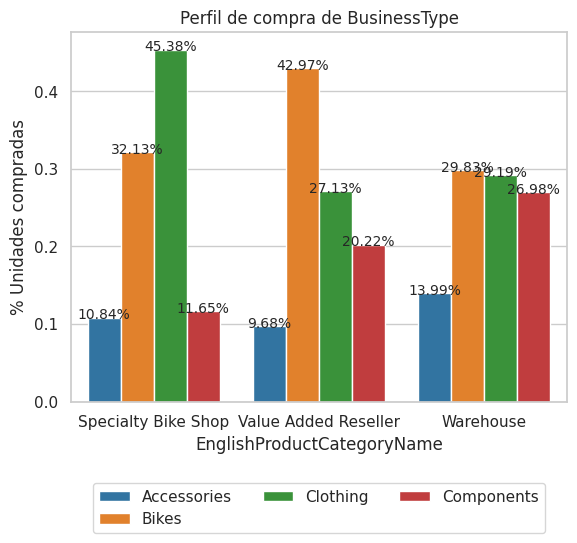

In [34]:
df_business_by_cat['percBusinessCatNumUnits'] = pd.to_numeric(df_business_by_cat['percBusinessCatNumUnits'], errors='coerce')

sns.set(style="whitegrid")

ax = sns.barplot(x='BusinessType', y='percBusinessCatNumUnits',
                 hue='EnglishProductCategoryName',
                 data=df_business_by_cat,
                 palette='tab10')

for p in ax.patches:
    ax.annotate('{:.2f}%'.format(p.get_height() * 100),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 2), textcoords='offset points',
                fontsize=10)

plt.xlabel('EnglishProductCategoryName')
plt.ylabel('% Unidades compradas')
plt.title('Perfil de compra de BusinessType')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)

plt.show()

2) Contraste de hipótesis

A continuación analizamos las variables de número de líneas, número de unidades compradas y promedio de unidades compradas por tipo de cliente y si la compra fue realizada con una promoción de volumen.


En esta tabla observamos que los Warehouse constituyen el mayor comprador con descuento por volumen. En particular, el 5% del total de sus líneas de compra y el 18% de sus unidades compradas fueron realizadas con un descuento por volumen.
Respecto al promedio de unidades compradas por línea, observamos un mayor promedio general de unidades compradas en las compras realizadas con promociones de volumen, para todos los tipos de clientes.
Si existe una diferencia significativa entre los promedios por tipo de cliente es algo que queda fuera de este análisis.

In [35]:
tabla_formateada = tabulate(df_business_gral[['BusinessType', 'volProm', 'percBusinessPromLines', 'percBusinessPromNumUnits', 'avgBusinessPromOrderQty']].drop_duplicates().drop_duplicates(),
                            tablefmt="simple_outline",
                            headers='keys',
                            showindex=False)

print(tabla_formateada)


BusinessType          volProm      percBusinessPromLines    percBusinessPromNumUnits    avgBusinessPromOrderQty
--------------------  ---------  -----------------------  --------------------------  -------------------------
Specialty Bike Shop   noVolProm               0.990234                     0.947364                     2.64433
Specialty Bike Shop   VolProm                 0.00976587                   0.0526363                   14.8974
Value Added Reseller  noVolProm               0.982653                     0.909325                     2.9568
Value Added Reseller  VolProm                 0.017347                     0.0906748                   16.7018
Warehouse             noVolProm               0.946492                     0.814828                     3.47638
Warehouse             VolProm                 0.0535083                    0.185172                    13.9744


En los siguientes gráficos observamos que la cantidad de líneas de compras con promoción por volumen es pequeña en relación a las realizadas sin promoción por volumen, siendo el Warehouse el tipo de cliente que mayor cantidad de líneas de compras con promoción por volumen posee.

Sin embargo, si observamos la cantidad de unidades compradas con promoción por volumen observamos una mayor proporción en relación a las unidades compradas por fuera de una promoción de volumen.

Todo este análisis nos sugiere que la promoción por volumen afecta el patrón de compra de los clientes, haciendo que se realicen menos ordenes pero con mayor cantidad de productos por orden.

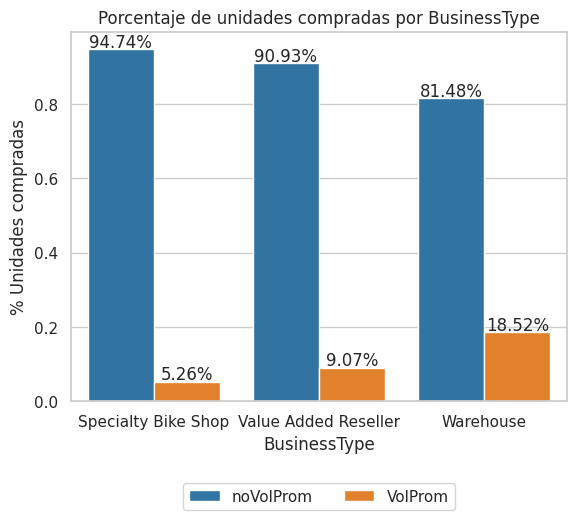

In [36]:
sns.set(style="whitegrid")

ax = sns.barplot(x='BusinessType', y='percBusinessPromNumUnits',
                 hue='volProm',
                 data=df_business_gral,
                  palette='tab10')

for p in ax.patches:
    ax.annotate('{:.2f}%'.format(p.get_height() * 100),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.xlabel('BusinessType')
plt.ylabel('% Unidades compradas')

plt.title('Porcentaje de unidades compradas por BusinessType')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)

plt.show()

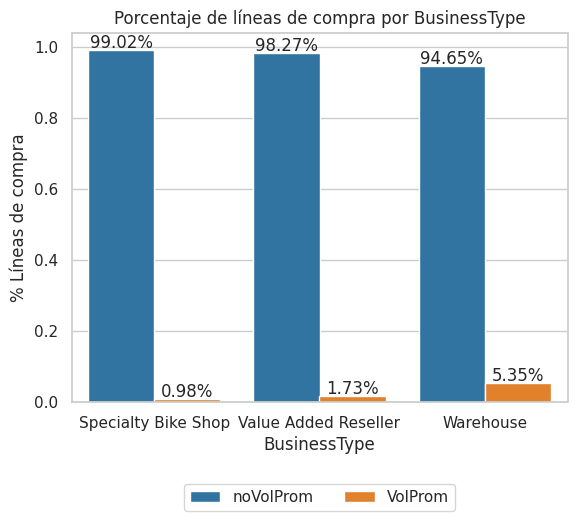

In [37]:
sns.set(style="whitegrid")

ax = sns.barplot(x='BusinessType', y='percBusinessPromLines',
                 hue='volProm',
                 data=df_business_gral,
                 palette='tab10')

for p in ax.patches:
    ax.annotate('{:.2f}%'.format(p.get_height() * 100),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')


plt.xlabel('BusinessType')
plt.ylabel('% Líneas de compra')

plt.title('Porcentaje de líneas de compra por BusinessType')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)

plt.show()

Ahora procedemos a analizar cuáles son las promociones más aprovechadas según el tipo de cliente.

In [38]:
df_business_by_prom['percBusinessPromKeyNumUnits'] = pd.to_numeric(df_business_by_prom['percBusinessPromKeyNumUnits'], errors='coerce')


En este gráfico, observamos que el Warehouse es el tipo de cliente que más aprovecha las promociones 2 y 3, constituyendo el 11 y el 6% de sus unidades compradas respectivamente.

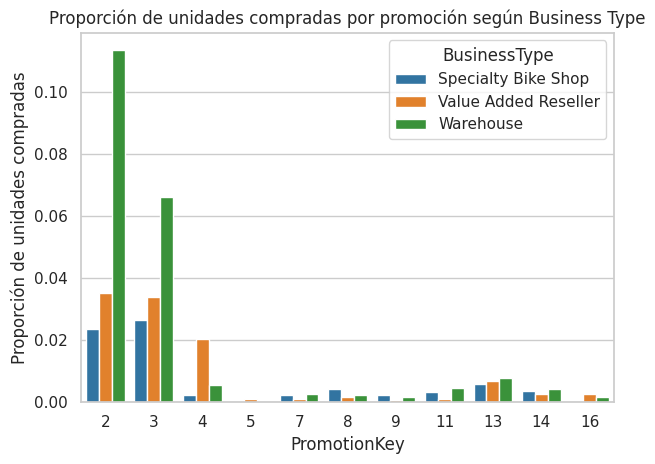

In [39]:
sns.set(style="whitegrid")

sns.barplot(x='PromotionKey',
            y='percBusinessPromKeyNumUnits',
            hue='BusinessType', data=df_business_by_prom[df_business_by_prom['PromotionKey']!=1],
            #hue='BusinessType', data=df_business_by_prom,

            palette='tab10')


plt.xlabel('PromotionKey')
plt.ylabel('Proporción de unidades compradas')
plt.title('Proporción de unidades compradas por promoción según Business Type')

plt.tight_layout()

plt.show()

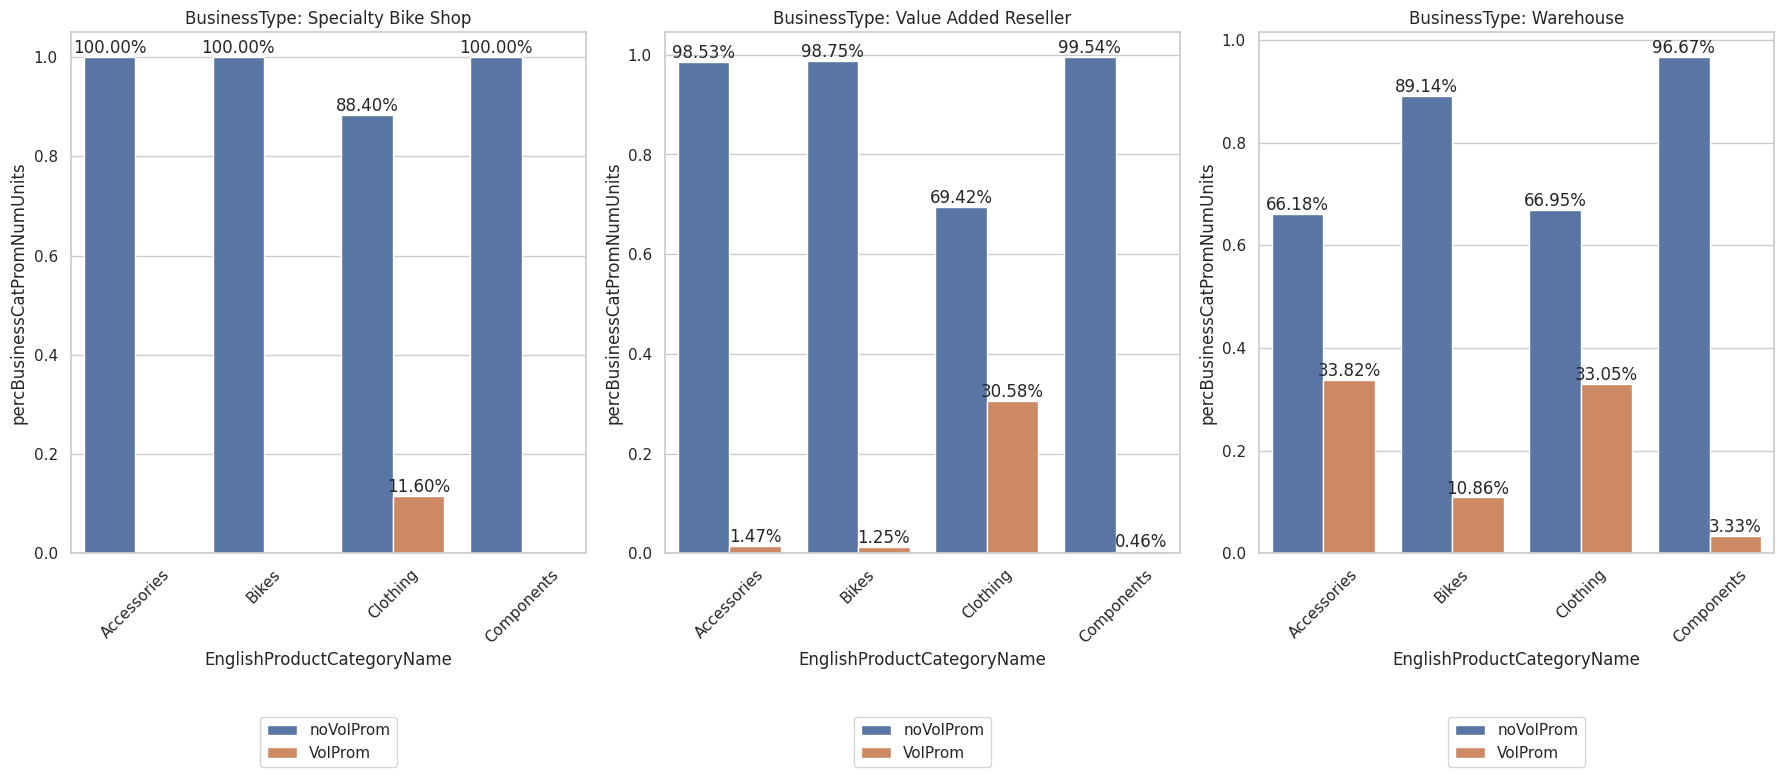

In [40]:
fig, axs = plt.subplots(1, 3, figsize=(18, 8))

for i, categoria1_valor in enumerate(df_business_by_cat['BusinessType'].unique()):
    df_filtrado = df_business_by_cat[df_business_by_cat['BusinessType'] == categoria1_valor]
    sns.barplot(x='EnglishProductCategoryName', y='percBusinessCatPromNumUnits', hue='volProm', data=df_filtrado, ax=axs[i])
    axs[i].set_title('BusinessType: {}'.format(categoria1_valor))
    axs[i].legend().remove()
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45)  # Rotar las etiquetas del eje x
    axs[i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=1)

    for p in axs[i].patches:
        height = p.get_height()
        axs[i].annotate('{:.2f}%'.format(height * 100), (p.get_x() + p.get_width() / 2, height), ha='center', va='bottom')



plt.subplots_adjust(bottom=0.2)


plt.tight_layout()


plt.show()


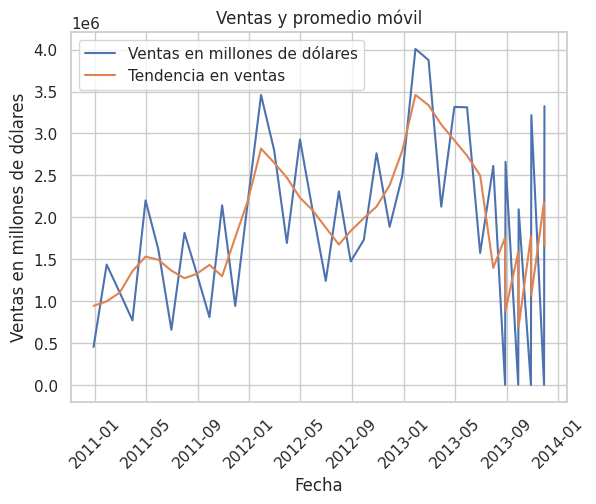

In [41]:

#Graficos

datos = time_series_medias_moviles


sns.set(style="whitegrid")

fig, ax = plt.subplots()

# serie de tiempo de ventas
ax.plot(datos['OrderDate'], datos['Sales'], label='Ventas en millones de dólares')

# serie de tiempo del promedio móvil
ax.plot(datos['OrderDate'], datos['SalesMovingAverage'], label='Tendencia en ventas')


ax.set_xlabel('Fecha')
ax.set_ylabel('Ventas en millones de dólares')
ax.set_title('Ventas y promedio móvil')

ax.legend()

plt.xticks(rotation=45)

plt.show()

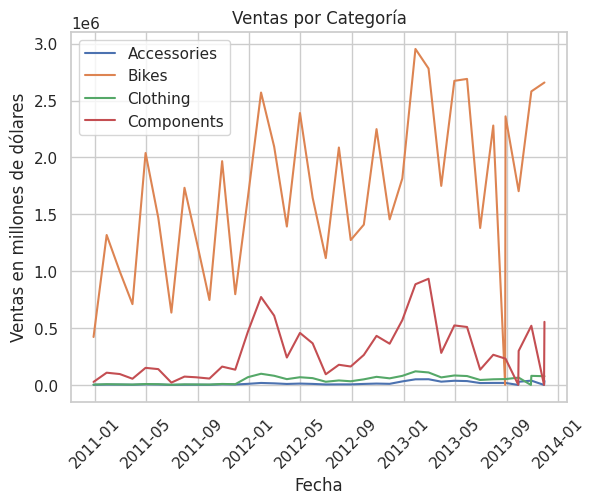

In [42]:
datos = time_series_por_producto

sns.set(style="whitegrid")

fig, ax = plt.subplots()

grupos = datos.groupby('EnglishProductCategoryName')

for grupo, datos_grupo in grupos:
    ax.plot(datos_grupo['OrderDate'], datos_grupo['Sales'], label=grupo)

ax.set_xlabel('Fecha')
ax.set_ylabel('Ventas en millones de dólares')
ax.set_title('Ventas por Categoría')

ax.legend()

plt.xticks(rotation=45)

plt.show()


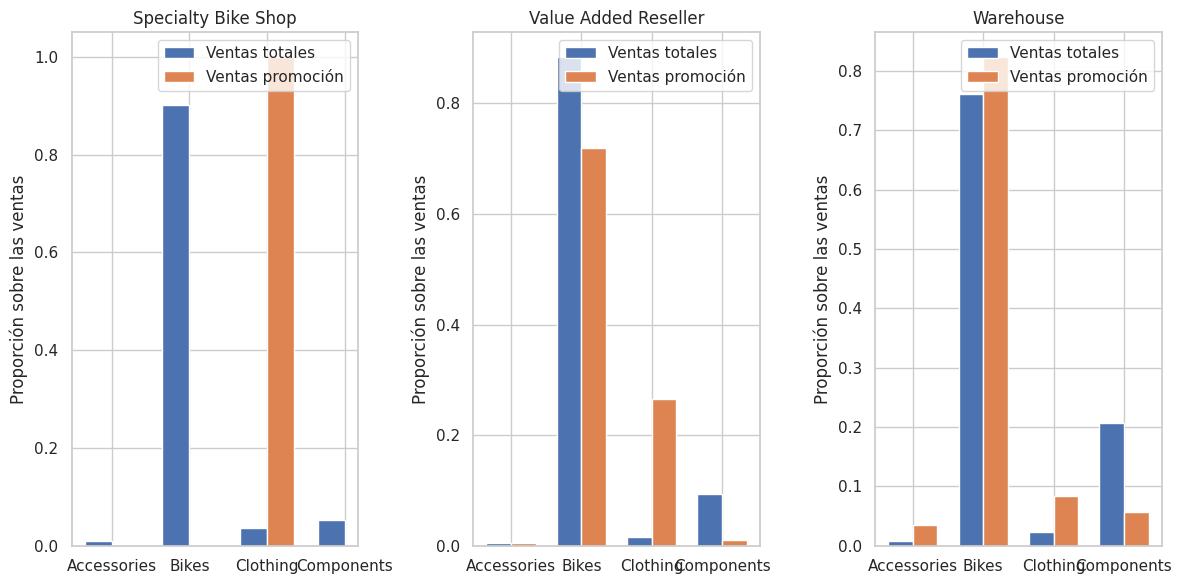

In [44]:
# Obtener los valores únicos de la columna 'BusinessType'
business_types = product_categories_analysis['BusinessType'].unique()

# Calcular el número de filas y columnas para los subplots
num_rows = 1
num_cols = len(business_types)

# Configuración de estilo de Seaborn
sns.set(style="whitegrid")

# Crear la figura y los ejes de los subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

# Iterar por cada elemento de 'BusinessType' y generar un gráfico de barras
for i, business_type in enumerate(business_types):
    # Filtrar los datos por el 'BusinessType' actual
    data = product_categories_analysis[product_categories_analysis['BusinessType'] == business_type]

    # Determinar los datos para cada par de barras
    grupos = data['EnglishProductCategoryName'].unique()
    valores1 = data.groupby('EnglishProductCategoryName')['proporcion_total_venta_producto_en_cliente'].mean()
    valores2 = data.groupby('EnglishProductCategoryName')['proporcion_promo_venta_producto_en_cliente'].mean()

    # Configurar las posiciones de las barras
    posiciones = range(len(grupos))
    ancho_barras = 0.35

    # Dibujar las barras en el subplot correspondiente
    ax = axes[i] if num_cols > 1 else axes
    barras1 = ax.bar(posiciones, valores1, width=ancho_barras, label='Ventas totales')
    barras2 = ax.bar([p + ancho_barras for p in posiciones], valores2, width=ancho_barras, label='Ventas promoción')

    # Configurar las etiquetas del eje x y el título
    ax.set_xticks([p + ancho_barras / 2 for p in posiciones])
    ax.set_xticklabels(grupos)
    # ax.set_xlabel('Grupos')
    ax.set_ylabel('Proporción sobre las ventas')
    ax.set_title(f'{business_type}')

    # Agregar una leyenda
    ax.legend()

# Ajustar los espacios entre los subplots
plt.tight_layout()

# Mostrar la visualización
plt.show()
